# Association Rule Mining Algorithms

Here we'll explore some more algorithms related to Association Rule Mining, mainly, ECLAT and CLOSET+

## Import Libraries 

In [4]:
from get_association_rules import generate_association_rules
from plot_rules import plot_rules_scatter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from collections import defaultdict, Counter
warnings.filterwarnings('ignore')

In [5]:
sns.set_style('whitegrid')

## Read Data

In [7]:
df = pd.read_csv('strong_association_transactions.csv')
df.head()

,Transaction
0,"Milk, Eggs, Bread, Butter, Cheese"
1,"Yogurt, Milk, Cereal, Bread, Butter"
2,"Yogurt, Milk, Eggs, Fruits, Bread, Butter, Cheese"
3,"Eggs, Milk, Bread"
4,"Butter, Milk, Bread"


In [8]:
transactions = [str(row).split(', ') for row in df['Transaction'] if pd.notnull(row)]

In [9]:
n = len(transactions)

## ECLAT Algorithm

ECLAT (Equivalence Class Transformation) is an algorithm used for frequent itemset mining based on a **vertical database layout**. Unlike Apriori, which uses a horizontal format (transactions as rows), ECLAT represents the data as:

*item → list of transaction IDs (TID set)*


Instead of scanning all transactions repeatedly, ECLAT intersects the TID lists of itemsets to find their support.

**Working of ECLAT Algorithm:**
- Convert transactions to vertical format (TID sets)
- Generate 2-itemsets by intersecting TID sets
- Continue recursively (depth-first)

Keep going until:
- TID set length < min_support, or
- No further items to combine

In [14]:
def get_vertical_format(transactions):
    vertical_data = {}
    for tid, transaction in enumerate(transactions):
        for item in transaction:
            if item not in vertical_data:
                vertical_data[item] = set()
            vertical_data[item].add(tid)
    return vertical_data

In [15]:
def eclat(prefix, items_tidsets, min_support, frequent_itemsets):
    items = list(items_tidsets.items())

    for i, (item, tidset) in enumerate(items):
        support = len(tidset)
        if support >= min_support:
            new_itemset = prefix + [item]
            frequent_itemsets[tuple(sorted(new_itemset))] = support

            # Build new candidate itemsets
            new_items = {}
            for j in range(i + 1, len(items)):
                next_item, next_tidset = items[j]
                intersected = tidset & next_tidset
                if len(intersected) >= min_support:
                    new_items[next_item] = intersected

            # Recursion
            if new_items:
                eclat(new_itemset, new_items, min_support, frequent_itemsets)

In [16]:
def run_eclat(transactions, min_support, normalized):
    vertical_data = get_vertical_format(transactions)
    frequent_itemsets = {}

    if normalized:
        abs_support = int(min_support * len(transactions))
        abs_support = max(abs_support, 1)  # ensure at least 1
    else:
        abs_support = min_support

    eclat([], vertical_data, abs_support, frequent_itemsets)
    return frequent_itemsets

In [17]:
frequent_itemsets = run_eclat(transactions, min_support = 0.4, normalized = True)

In [18]:
for itemset, support in frequent_itemsets.items():
    n_support = support/n
    print(f"{itemset}: {n_support:.2f}")

('Milk',): 0.73
('Eggs', 'Milk'): 0.41
('Bread', 'Eggs', 'Milk'): 0.40
('Bread', 'Milk'): 0.72
('Bread', 'Butter', 'Milk'): 0.46
('Bread', 'Cheese', 'Milk'): 0.41
('Butter', 'Milk'): 0.46
('Cheese', 'Milk'): 0.42
('Eggs',): 0.57
('Bread', 'Eggs'): 0.51
('Bread', 'Cheese', 'Eggs'): 0.46
('Cheese', 'Eggs'): 0.52
('Bread',): 0.91
('Bread', 'Butter'): 0.64
('Bread', 'Cheese'): 0.52
('Butter',): 0.66
('Cheese',): 0.58


 ### Visualization of Itemsets

In [20]:
def plot_frequent_itemsets_bar(frequent_itemsets):
    sorted_items = sorted(frequent_itemsets.items(), key=lambda x: x[1], reverse=True)
    itemsets = ['+'.join(item[0]) for item in sorted_items]
    supports = [item[1] for item in sorted_items]

    plt.figure(figsize=(12, 6))
    bars = sns.barplot(x=supports, y=itemsets, palette="viridis")
    plt.xlabel("Support")
    plt.ylabel("Itemsets")
    plt.title("Frequent Itemsets Support")

    # Annotate support values on bars
    for bar, support in zip(bars.patches, supports):
        width = bar.get_width()
        plt.text(width + 0.01, bar.get_y() + bar.get_height() / 2,
                 f'{support:.2f}', va='center', ha='left', fontsize=10)

    plt.tight_layout()
    plt.show()

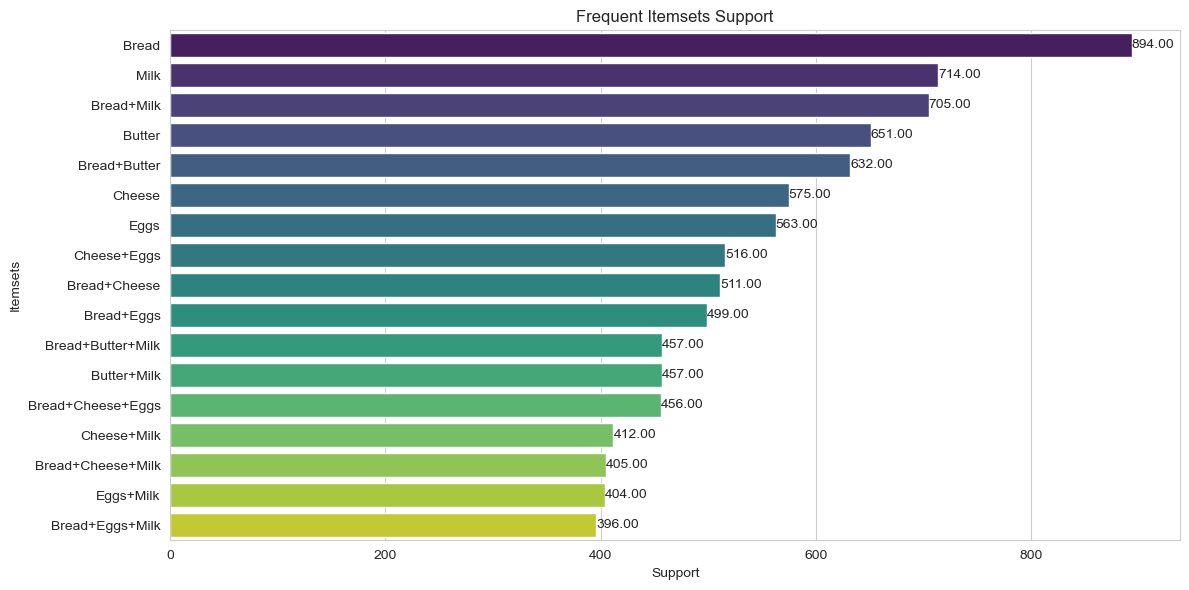

In [21]:
plot_frequent_itemsets_bar(frequent_itemsets)

### Candidate Rule Generation

Minimum Confidence: 75%

In [24]:
f = {frozenset(k): v for k, v in frequent_itemsets.items()}
rules = generate_association_rules(f, transactions, min_confidence=0.75) 

In [25]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,jaccard,kulczynski,zhangs_metric,certainty,representativity
0,(Cheese),(Eggs),0.584350,0.572154,0.524390,0.897391,1.568442,0.190052,4.169681,0.829582,0.906955,0.871946,0.760173,0.897391
1,(Eggs),(Cheese),0.572154,0.584350,0.524390,0.916519,1.568442,0.190052,4.978961,0.829582,0.906955,0.847093,0.799155,0.916519
2,(Cheese),"(Eggs, Bread)",0.584350,0.507114,0.463415,0.793043,1.563837,0.167083,2.381593,0.737864,0.853436,0.867429,0.580113,0.793043
3,"(Eggs, Bread)",(Cheese),0.507114,0.584350,0.463415,0.913828,1.563837,0.167083,4.823478,0.737864,0.853436,0.731502,0.792681,0.913828
4,(Eggs),"(Bread, Cheese)",0.572154,0.519309,0.463415,0.809947,1.559663,0.166290,2.529244,0.737864,0.851157,0.838704,0.604625,0.809947
5,"(Bread, Cheese)",(Eggs),0.519309,0.572154,0.463415,0.892368,1.559663,0.166290,3.975074,0.737864,0.851157,0.746500,0.748432,0.892368
6,"(Milk, Butter)",(Bread),0.464431,0.908537,0.464431,1.000000,1.100671,0.042478,inf,0.511186,0.755593,0.170778,1.000000,1.000000
7,"(Eggs, Bread)",(Milk),0.507114,0.725610,0.402439,0.793587,1.093683,0.034472,1.329327,0.484700,0.674105,0.173789,0.247740,0.793587
8,"(Bread, Cheese)",(Milk),0.519309,0.725610,0.411585,0.792564,1.092273,0.034770,1.322768,0.493902,0.679895,0.175742,0.244010,0.792564
9,(Milk),(Bread),0.725610,0.908537,0.716463,0.987395,1.086797,0.057220,7.256098,0.780731,0.887993,0.291064,0.862185,0.987395


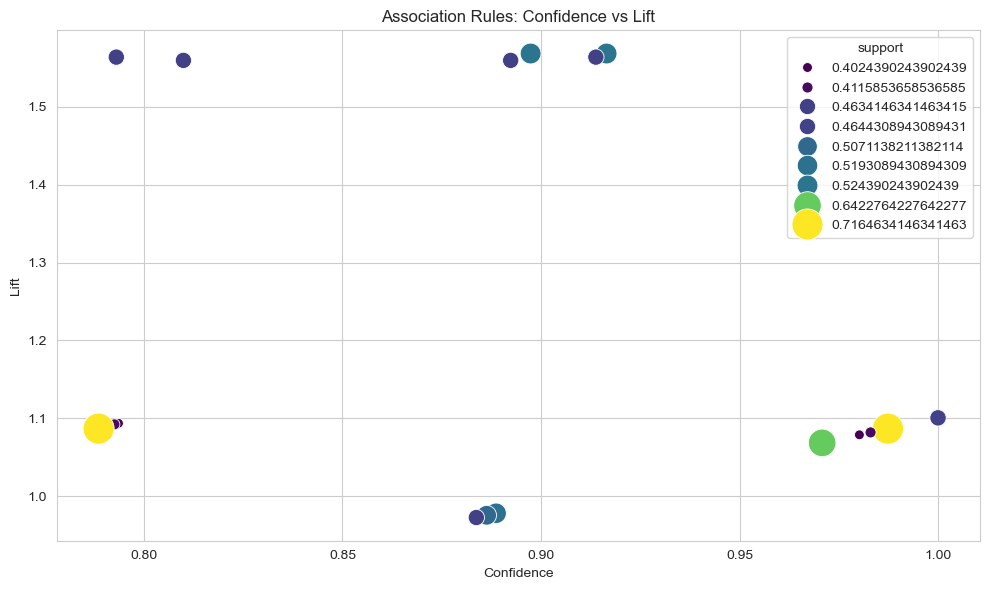

In [26]:
plot_rules_scatter(rules)

## CLOSET+ Algorithm

CLOSET+ stands for **"Closed Itemset Mining by Pattern-Growth with Itemset Projection."**

It's an enhanced version of:

- CLOSET: Uses an FP-tree-like structure (called a compact prefix tree).

- FP-Growth: Avoids candidate generation.

- But CLOSET+ adds techniques to prune the search space more aggressively, compress the database, and eliminate redundant work.



**Flow of CLOSET+**:

Input: Transaction DB, min_sup 

-> Build FP-Tree (compact prefix tree) 

-> Mine recursively using itemset projection 

-> For each node/item:
- Check closure property
- Check parent equivalence (prune)
- Project conditional tree
- Use diffsets for support counting

->Output: Closed frequent itemsets


In [31]:
def get_frequent_items(transactions, abs_min_support):
    item_counter = Counter()
    for transaction in transactions:
        item_counter.update(transaction)
    return {
        item: count
        for item, count in item_counter.items()
        if count >= abs_min_support
    }

def sort_transaction(transaction, freq_items):
    return sorted(
        [item for item in transaction if item in freq_items],
        key=lambda x: (-freq_items[x], x)
    )

def closet_plus_mine(transactions, prefix, freq_items, closed_itemsets, abs_min_support):
    item_tidlist = defaultdict(set)

    for tid, transaction in enumerate(transactions):
        for item in transaction:
            if item in freq_items:
                item_tidlist[item].add(tid)

    for item, tidlist in item_tidlist.items():
        support = len(tidlist)
        if support < abs_min_support:
            continue

        new_prefix = prefix + [item]
        new_prefix_set = frozenset(new_prefix)

        # Closure check
        is_closed = True
        to_remove = []
        for existing in closed_itemsets:
            if existing.issuperset(new_prefix_set) and closed_itemsets[existing] == support:
                is_closed = False
                break
            if new_prefix_set.issuperset(existing) and closed_itemsets[existing] == support:
                to_remove.append(existing)

        if is_closed:
            for r in to_remove:
                del closed_itemsets[r]
            closed_itemsets[new_prefix_set] = support

        # Build projected database
        projected_db = []
        for tid in tidlist:
            transaction = transactions[tid]
            if item in transaction:
                idx = transaction.index(item)
                suffix = transaction[idx + 1:]
                projected_suffix = [x for x in suffix if x in freq_items]
                if projected_suffix:
                    projected_db.append(projected_suffix)

        if projected_db:
            closet_plus_mine(projected_db, new_prefix, freq_items, closed_itemsets, abs_min_support)

def closet_plus(transactions, min_support=0.5):
    if not 0 < min_support <= 1:
        raise ValueError("min_support must be between 0 and 1 (normalized).")
    
    total_transactions = len(transactions)
    abs_min_support = int(min_support * total_transactions)

    freq_items = get_frequent_items(transactions, abs_min_support)
    sorted_transactions = [sort_transaction(t, freq_items) for t in transactions]
    closed_itemsets = {}
    closet_plus_mine(sorted_transactions, [], freq_items, closed_itemsets, abs_min_support)
    return closed_itemsets

Closed Itemsets generation with Minimum Support: 60%

In [33]:
closed_itemset = closet_plus(transactions, min_support=0.6)

In [34]:
output = [{'itemset': set(itemset), 'support': support}
          for itemset, support in closed_itemset.items()]

In [35]:
closed_itemsets = pd.DataFrame(output)

In [36]:
closed_itemsets

,itemset,support
0,{Bread},894
1,"{Milk, Bread}",705
2,"{Butter, Bread}",632
3,{Milk},714
4,{Butter},651


### Rule Generation
Minimum Confidence: 75&

In [38]:
frequent_itemsets_dict = dict(zip(closed_itemsets['itemset'].apply(frozenset), closed_itemsets['support']))
rules2 = generate_association_rules(frequent_itemsets_dict, transactions, min_confidence=0.75)

In [39]:
rules2

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,jaccard,kulczynski,zhangs_metric,certainty,representativity
0,(Milk),(Bread),0.725610,0.908537,0.716463,0.987395,1.086797,0.057220,7.256098,0.780731,0.887993,0.291064,0.862185,0.987395
1,(Bread),(Milk),0.908537,0.725610,0.716463,0.788591,1.086797,0.057220,1.297909,0.780731,0.887993,0.873191,0.229530,0.788591
2,(Butter),(Bread),0.661585,0.908537,0.642276,0.970814,1.068547,0.041202,3.133825,0.692223,0.838875,0.189560,0.680901,0.970814


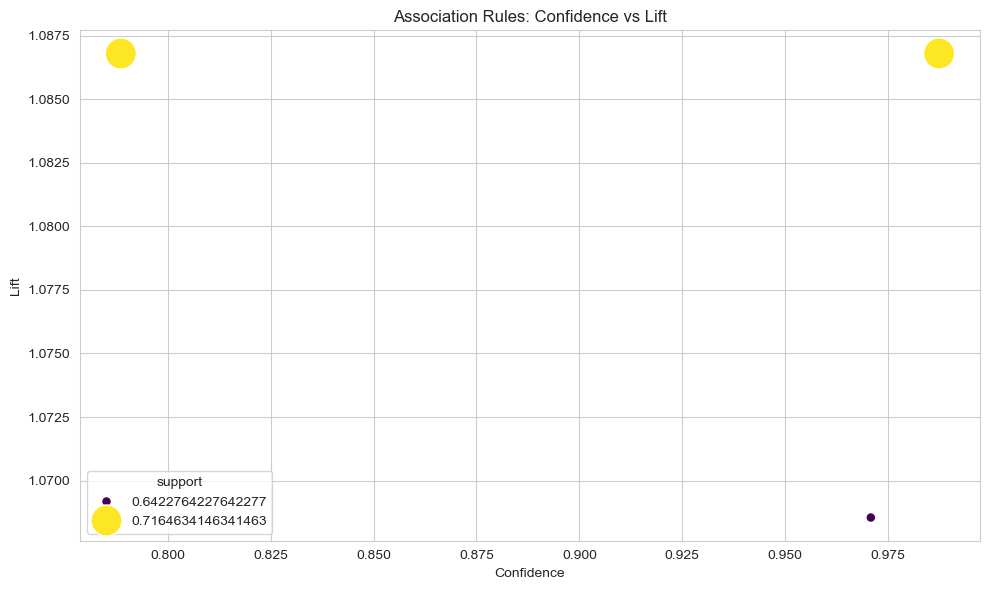

In [40]:
plot_rules_scatter(rules2)